# Calculate Radar Vegetation Index(RVI) using Sentinel-1 GRD collection

In this notebook, we want to study the health condition of vegetation using radar. Thus, we will use the Sentinel-1 GRD collection available within the Copernicus Data Space Ecosystem.  The Radar Vegetation Index (RVI) is a measure used in remote sensing and agriculture to assess the health and condition of vegetation using radar data. 

RVI has been used in several research studies, especially for predicting the growth level of crop vegetation over time and many more. However, here, we will stick to a simple example of calculating RVI.

The formula adopted in this notebook is as follows:

$$\mathrm{RVI}=\frac{4 \sigma^0_{VH}}{\sigma^0_{VV}+\sigma^0_{VH}}$$,

where $\sigma^0_{VH}$, $\sigma^0_{VV}$ and $\sigma^0_{VH}$ are the polarised backscattering coefficients,

Reference:
* https://www.mdpi.com/2076-3417/9/4/655
* https://forum.step.esa.int/t/creating-radar-vegetation-index/12444/18

In [1]:
import openeo

import matplotlib.pyplot as plt
from matplotlib import gridspec
import xarray as xr

In [2]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


## Load the collection

In [3]:
s1 = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent={"west": 5.15, "south": 51.20, "east": 5.25, "north": 51.35},
    bands=["VV", "VH"],
)

Given that the "gamma0-terrain" coefficient is not currently supported in the openEO backend implementation of the Copernicus Data Space Ecosystem at the time of preparing this notebook, we use the "sigma0-ellipsoid" coefficient for SAR backscattering computation.

In [4]:
s1 = s1.sar_backscatter(coefficient="sigma0-ellipsoid")

Let's apply the formula mentioned above:

In [5]:
rvi = (4 * s1.band("VH")) / (s1.band("VV") + s1.band("VH"))

In [6]:
rvi.download("RVI.nc")

## Let's plot the RVI result

In the above process, we download RVI data over a specified time period. Now, let us plot the summary of the RVI for a pixel over the temporal period for the selected region. For example, it showcases the mean value calculated over the given temporal period. Furthermore, let us also, visualise the mean NDVI timeseries for this area plotted with time across RVI value.

In [7]:
ds = xr.load_dataset("RVI.nc")
data = ds[["var"]].to_array(dim="bands")

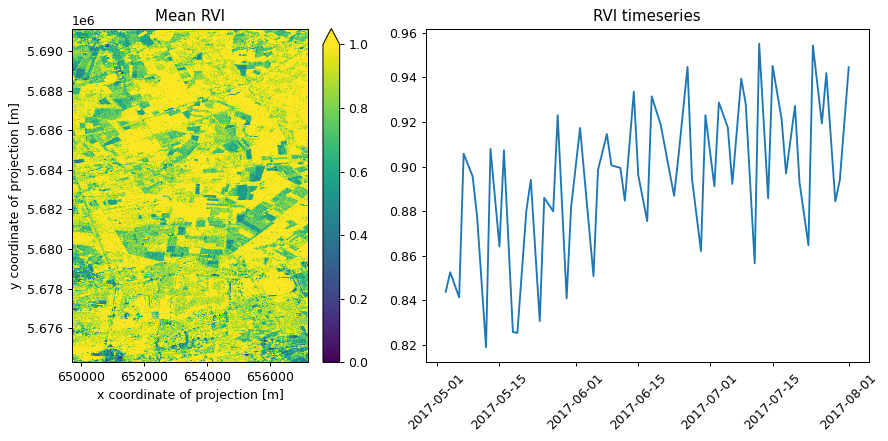

In [8]:
fig = plt.figure(figsize=(10, 5), dpi=90)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])

# Plot the image
ax0 = plt.subplot(gs[0])
data.mean(dim="t")[0].plot.imshow(vmin=0, vmax=1, ax=ax0)
ax0.set_title("Mean RVI")

# Plot the timeseries
ax1 = plt.subplot(gs[1])
ax1.plot(data.t.to_numpy(), data.mean(dim=("x", "y"))[0])
ax1.set_title("RVI timeseries")

plt.xticks(rotation=45)
plt.tight_layout()

So, looking at the plot, it looks like the vegetation has increased over time.

## Using Awesome Spectral Indices

The openEO Python client has a [spectral indices](https://open-eo.github.io/openeo-python-client/cookbook/spectral_indices.html) feature to simplify building process graphs with indices like RVI. It builds on the [Awesome Spectral Indices](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/) project and allows specifying indices through their name instead of having to deal with formulas.

*However, please note that this API is experimental and may undergo changes. Furthermore, there might be cases where it is not supported for certain collections when executed directly in the openEO web editor.*

For example, with the compute_indices help,,r you just have to specify "DpRVIVV" (Dual-Polarized Radar Vegetation Index VV) as follows:

In [9]:
from openeo.extra.spectral_indices import compute_indices

In [10]:
indices = compute_indices(
    s1,
    indices=["DpRVIVV"],
)

In [11]:
indices.download("RVI_direct.nc")

In [12]:
ds_indices = xr.load_dataset("RVI_direct.nc")
data = ds_indices[["DpRVIVV"]].to_array(dim="bands")

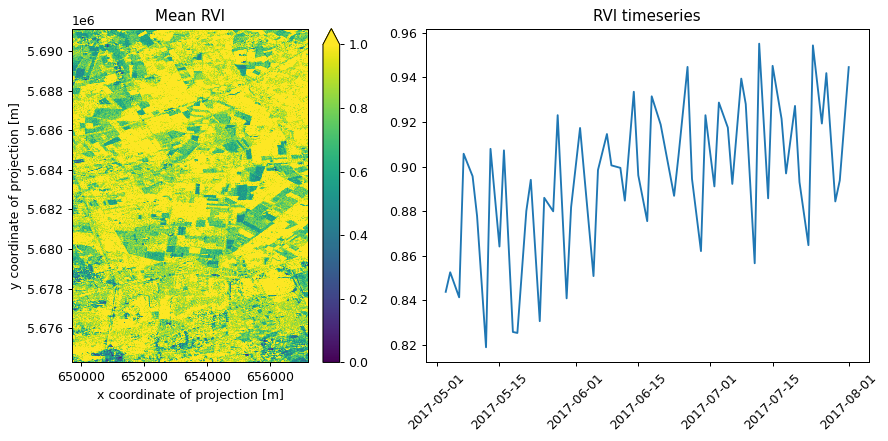

In [13]:
fig = plt.figure(figsize=(10, 5), dpi=90)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])

# Plot the image
ax0 = plt.subplot(gs[0])
data.mean(dim="t")[0].plot.imshow(vmin=0, vmax=1, ax=ax0)
ax0.set_title("Mean RVI")

# Plot the timeseries
ax1 = plt.subplot(gs[1])
ax1.plot(ds_indices.t.to_numpy(), data.mean(dim=("x", "y"))[0])
ax1.set_title("RVI timeseries")

plt.xticks(rotation=45)
plt.tight_layout()